In [386]:
import os
import pandas as pd

import re
import string
import requests
from bs4 import BeautifulSoup
from bs4.diagnose import diagnose

from wordcloud import WordCloud
from textblob import TextBlob
from textblob import Word

from __future__ import division

import matplotlib.pyplot as plt
%matplotlib inline


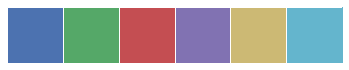

In [601]:
import seaborn as sns

plt.style.use('seaborn-notebook')

sns.set_style('whitegrid')
sns.set_palette('muted')
sns.set(font_scale=2)
sns.set(color_codes=True)
sns.set(rc={'figure.figsize': (6.0, 4.0), 
            'xtick.labelsize': 16, 
            'ytick.labelsize': 16,
            'axes.labelweight': 'bold',
            'legend.fontsize': 16,
            'axes.labelsize': 16,
           'axes.titlesize': 20,
           'axes.titleweight': 'bold'})

current_palette = sns.color_palette()
sns.palplot(current_palette)


In [235]:
def get_text(url):
    '''scrapes text from a website'''
    data=""
    p=requests.get(url).content
    soup=BeautifulSoup(p,'lxml')    
    paragraphs=soup.select("p.story-body-text.story-content")
    data=p
    text=""
    for paragraph in paragraphs:
        text+=paragraph.text
    text=text.encode('ascii', 'ignore')
    return str(text)

In [236]:
debate2 = get_text('http://www.nytimes.com/2016/10/10/us/politics/transcript-second-debate.html')
debate1 = get_text('http://www.nytimes.com/2016/09/27/us/politics/transcript-debate.html')

In [237]:
def match_speakers(debate):
    speakers2    = ['Trump', 'Clinton','Cooper','Raddatz']
    speakers1    = ['Trump', 'Clinton','Holt']

    if debate == debate1:
        return speakers1
    elif debate == debate2:
        return speakers2

In [238]:
def times_spoken_per_debate(debate):
    '''for a debate path and list of speakers returns the times a person spoke'''
    candidate_times = {}
    speakers = match_speakers(debate)
    #read transcript
    for s in speakers:
        s = s.upper() + ':'
        count = len(re.findall(s,debate))
        candidate_times[s.capitalize().strip(':')] = count
    if debate == debate1:
        candidate_times['Moderators'] = candidate_times['Holt']
    else: 
        candidate_times['Moderators'] = candidate_times['Raddatz'] + candidate_times['Cooper']
    return candidate_times


In [545]:


print 'Interjections in 1st debate'
print times_spoken_per_debate(debate1)
print 'Interjections in 2nd debate'
print times_spoken_per_debate(debate2)

Interjections in 1st debate
{'Moderators': 97, 'Holt': 97, 'Clinton': 94, 'Trump': 129}
Interjections in 2nd debate
{'Cooper': 75, 'Moderators': 136, 'Clinton': 61, 'Trump': 92, 'Raddatz': 61}


In [591]:
def plot_interjections(debate):
    df = pd.DataFrame.from_dict(times_spoken_per_debate(debate), orient='index')
    if debate == debate1:
        title = 'Interjections in First Debate'
    else:
        title = 'Interjections in Second Debate'
    
    df.columns = ['Interjections']
    names_of_interest = ['Clinton','Trump','Moderators']
    print (df.loc['Trump'] -df.loc['Clinton'])  / df.loc['Clinton']   
    df = df.loc[names_of_interest]
    #df.plot(kind='bar',title = title,legend = False)
    
    ax =  df.plot(kind='bar',title = title,legend = False)
    plt.xticks(rotation=0)
    #ax = df.plot()
    fig = ax.get_figure()
    fig.savefig(title + '.png')
    return fig

Interjections    0.37234
dtype: float64
Interjections    0.508197
dtype: float64


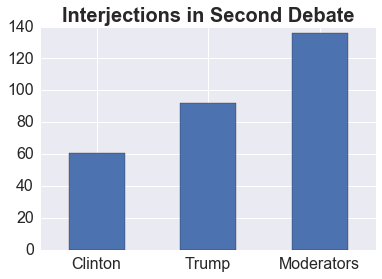

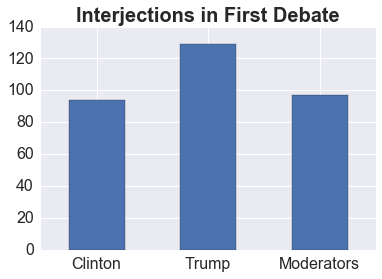

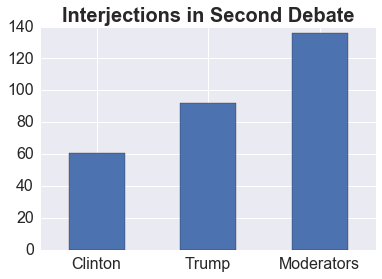

In [592]:
plt.rcParams['figure.figsize'] = 6, 4

plot_interjections(debate1)#.plot(ax=axs[0],kind = 'bar',title = 'Interjections in First Debate',legend=False)
plot_interjections(debate2)#.plot(ax=axs[1],kind = 'bar',title = 'Interjections in Second Debate',legend=False)


In [264]:
def create_dict_of_debate(debate):
    debate_dict = {}
    speakers = match_speakers(debate)
    for x in speakers:
        x = x.upper() + ':'
        debate_text = debate.replace('(APPLAUSE)','')
        all = re.findall(r'%s(.*?)[A-Z]{3}' %x, debate_text)
        #remove Holt intro, the 2nd debate transcript excludes the intro
        if x == 'HOLT:':
            all = all[1:]
        dialogue = "-".join(all) 
        x = x.replace(':','')
        x = x.capitalize()
        debate_dict[x] = dialogue
    return debate_dict



In [265]:
def create_dict_of_start_of_debate(debate_text,start,end):
    debate_dict = {}
    speakers = match_speakers(debate)
    for x in speakers:
        x = x.upper() + ':'
        debate_text = debate_text.replace('(APPLAUSE)','')
        all = re.findall(r'%s(.*?)[A-Z]{3}' %x, debate_text)
        #remove Holt intro, the 2nd debate transcript excludes the intro
        if x == 'HOLT:':
            all = all[1:]
        all = all[start:end]    
        dialogue = "-".join(all) 
        x = x.replace(':','')
        x = x.capitalize()
        debate_dict[x] = dialogue
    return debate_dict


In [266]:

def create_dict_of_periods_of_debate(debate,period,total_periods):
    debate_dict = {}
    debate_text = debate.replace('(APPLAUSE)','')
    speakers = match_speakers(debate)
    period = period - 1
    chunk_size = int(len(debate_text) / total_periods)
    i = period * chunk_size
    debate_text = debate1[i: i + chunk_size]

    for x in speakers:
        x = x.upper() + ':'

        all = re.findall(r'%s(.*?)[A-Z]{3}' %x, debate_text)

        
        dialogue = "-".join(all) 
        x = x.replace(':','')
        x = x.capitalize()
        debate_dict[x] = dialogue
    if debate_dict:
        return debate_dict


In [268]:
def convert_dict_to_df(a_dict):
    debate_df = pd.DataFrame.from_dict(a_dict,orient='index', dtype=None)
    debate_df.rename(columns={0: "text"},inplace = True)
    return debate_df
                 

In [269]:
debate_dict = create_dict_of_debate(debate1)
for key, value in debate_dict.iteritems():
    print key,':',len(value.split(" "))
    

Holt : 1648
Clinton : 4457
Trump : 6212


In [579]:
def plot_word_count(debate):
    
    debate_dict = create_dict_of_debate(debate)
    words_spoken_per_debate = {}
    for key, value in debate_dict.iteritems():
        words_spoken_per_debate[key] = len(value.split(" "))
        
    df = pd.DataFrame.from_dict(words_spoken_per_debate, orient='index')
    if debate == debate1:
        title = 'Words Spoken in First Debate'
    else:
        title = 'Words Spoken in Second Debate'
    
    df.columns = ['Interjections']
    names_of_interest = ['Clinton','Trump']
    df = df.loc[names_of_interest]
    df.plot(kind='bar',title = title,legend = False)
    plt.xticks(rotation=0)
    


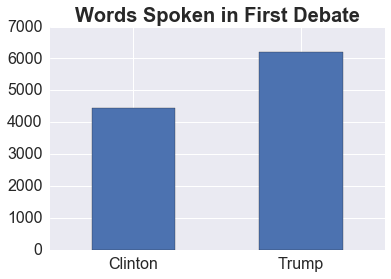

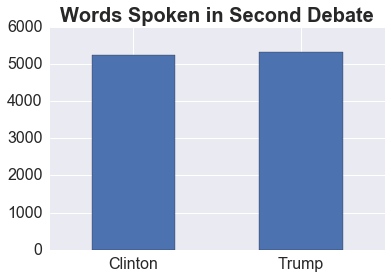

In [589]:
plt.rcParams['figure.figsize'] = 6, 4

plot_word_count(debate1)
fig.savefig('debate1_words' + '.png')

plot_word_count(debate2)
fig.savefig('debate2_words' + '.png')

In [614]:
def plot_narcissim_index(debate):
    
    debate_dict = create_dict_of_debate(debate)
    words_spoken_per_debate = {}
    for key, value in debate_dict.iteritems():
        words_spoken = len(value.split(" "))
        narcissism_count = 0
        for word in value.split(" "):
            if word in ['I',"I'm",'me','mine']:
                narcissism_count +=1
        words_spoken_per_debate[key] = narcissism_count / words_spoken
        
        
    df = pd.DataFrame.from_dict(words_spoken_per_debate, orient='index')
    if debate == debate1:
        title = '"Narcissism Index" \n Self Reference in First Debate'
    else:
        title = '"Narcissism Index" \n Self Reference in Second Debate'
    
    df.columns = ['Interjections']
    names_of_interest = ['Clinton','Trump']
    df = df.loc[names_of_interest]
    df.plot(kind='bar',title = title,legend = False).set(xlabel='Self Referential Terms ("I","I\'m","me","mine","my","My")')
    
    plt.xticks(rotation=0)

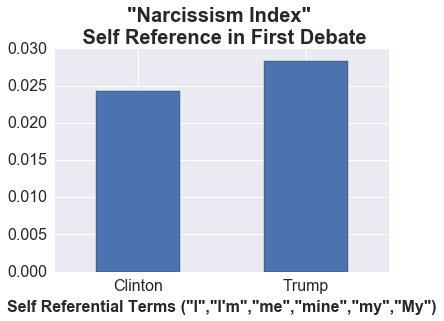

In [615]:
plot_narcissim_index(debate1)

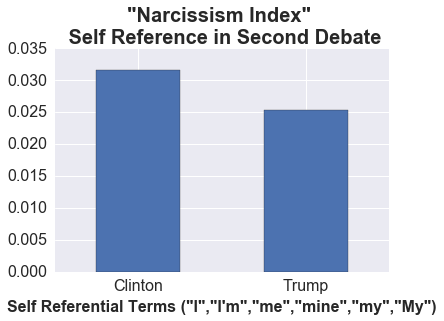

In [603]:
plot_narcissim_index(debate2)

In [606]:
def generate_wordcloud(df,debate):
    '''
     Generates wordcloud files in the /data folder
     one for each name in the speakers list
     the df dataframe has the following columns:
        'year', 'party', 'debate', 'candidate', 'text'
    '''
    speakers = match_speakers(debate)
    for p in speakers:
        print("Generating: %s" % p)
        wordcloud_filename = p.lower() + '1.png'
        wordcloud = WordCloud( max_words=500, width=900, height=600, background_color='white')
        text    =  df[df.index == p]['text'].get_values()[0]
        blob    = TextBlob(text)
        nouns   = [ word for word, pos in blob.tags if pos == 'NN' ]

        wordcloud.generate(' '.join(nouns))
        wordcloud.to_file(wordcloud_filename)
        image = wordcloud.to_image()
        
        #matplotlib.pyplot.imshow(image)
        fig = plt.figure()
        fig.suptitle(p, fontsize=14, fontweight='bold')
        plt.imshow(image)
    
        ## take relative word frequencies into account, lower max_font_size
        #wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(text)
    #plt.figure()
    #plt.imshow(wordcloud)
    #plt.axis("off")
    #plt.show()
speakers2    = ['Trump', 'Clinton','Cooper','Raddatz']
speakers1    = ['Trump', 'Clinton','Holt']

def plot_wordclouds(debate):
    debate_dict = create_dict_of_debate(debate)
    df = convert_dict_to_df(debate_dict)
    generate_wordcloud(df,debate)



Generating: Trump
Generating: Clinton
Generating: Holt


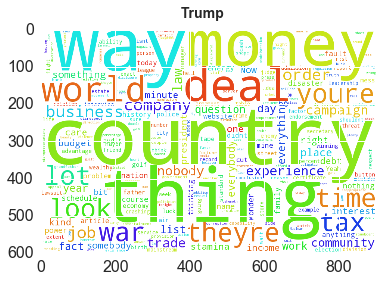

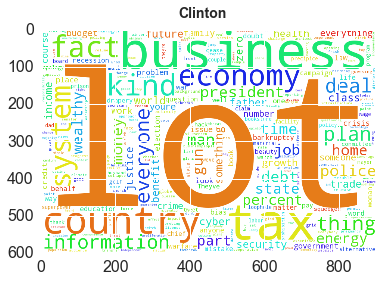

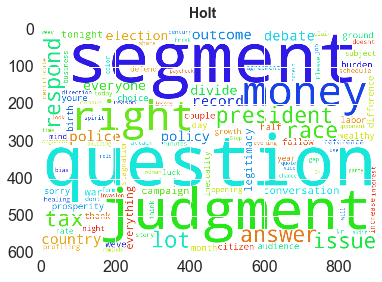

In [607]:
plot_wordclouds(debate1)


Generating: Trump
Generating: Clinton
Generating: Cooper
Generating: Raddatz


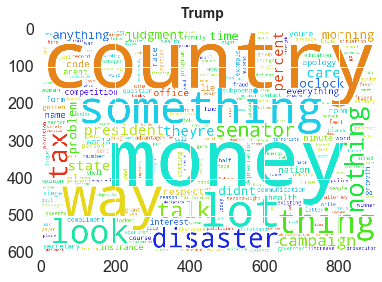

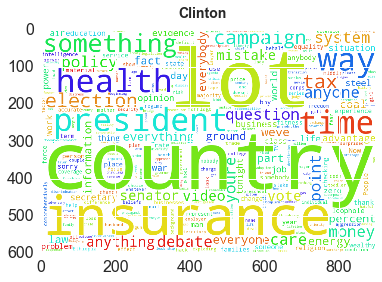

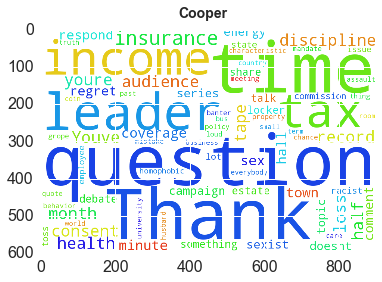

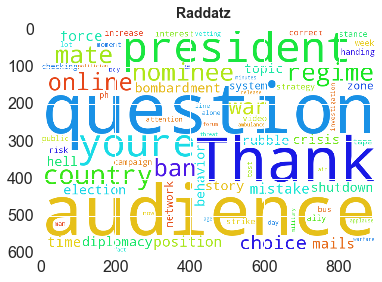

In [608]:
plot_wordclouds(debate2)

In [292]:
def print_sentiment_analysis(speakers,debate,start,end):
    debate_dict = create_dict_of_start_of_debate(speakers,debate,start,end)
    for key, value in debate_dict.iteritems():
        if key == 'Clinton' or key == 'Trump':
            print key
            transcript = TextBlob(value)
            #print transcript.sentiment
            print transcript.sentiment.polarity


In [367]:
def get_sentiment_analysis(speaker,debate,period,total_periods):
    debate_dict = create_dict_of_periods_of_debate(debate,period,total_periods)
    #print debate_dict
    transcript = TextBlob(debate_dict[speaker])
    n =  transcript.sentiment.polarity
    return round(n,3)
    

In [368]:
get_sentiment_analysis('Clinton',debate1,2,8)

0.211

In [369]:
def create_dataframe_of_sentiment(debate,total_periods):
    # create index
    time_periods = [x for x in xrange(1,(total_periods+1))]
    df = pd.DataFrame(index= time_periods)
    df['Clinton'] = [get_sentiment_analysis('Clinton',debate,x,total_periods) for x in xrange(1,(total_periods+1))]
    df['Trump'] = [get_sentiment_analysis('Trump',debate,x,total_periods) for x in xrange(1,(total_periods+1))]
    #df[speaker] = get_sentiment_analysis(speaker,debate,period,total_periods)
    return df
    #for x in
    

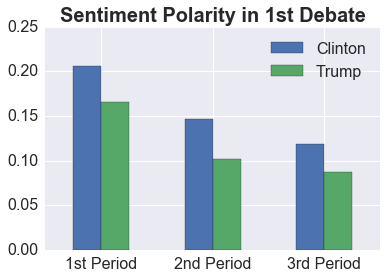

In [626]:
df = create_dataframe_of_sentiment(debate1,3)
ax = df.plot(kind = 'bar',title = 'Sentiment Polarity in 1st Debate')
#ax.set_xticks( [ 0.5, 1.5, 2.5 ] )
ax.set_xticklabels( ['1st Period','2nd Period','3rd Period'], rotation=45 ) 


plt.xticks(rotation=0)

#plt.set.xlabel='30 Minute Period of Debate'
fig = ax.get_figure()
fig.savefig('first' + '.png')

In [371]:
df

,Clinton,Trump
1,0.208,0.236
2,0.115,0.078
3,0.139,0.161
4,0.178,0.077


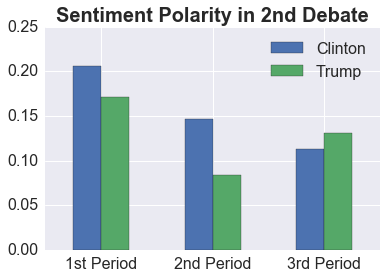

In [628]:
df2 = create_dataframe_of_sentiment(debate2,3)

ax = df2.plot(kind = 'bar',title = 'Sentiment Polarity in 2nd Debate')
ax.set_xticklabels( ['1st Period','2nd Period','3rd Period'], rotation=45 ) 


plt.xticks(rotation=0)

#plt.set.xlabel='30 Minute Period of Debate'
fig = ax.get_figure()
fig.savefig('second' + '.png')

In [383]:
df

,Clinton,Trump
1,0.180,0.126
2,0.149,0.106


In [380]:
df2

,Clinton,Trump
1,0.180,0.161
2,0.147,0.102


In [ ]:
def sentiment_df(debate,periods):
    
create_dataframe_of_sentiment(speaker,debate,total_periods)

In [197]:
sentiment_dict = {}
for x in xrange(1,8):
    print_sentiment_analysis(speakers1,debate1,x,8)

('Clinton', 0.2515603557440292)
('Trump', 0.2668064182194617)
('Clinton', 0.2106060606060606)
('Trump', 0.18603380746237888)
('Clinton', 0.0755952380952381)
('Trump', 0.08952075702075701)
('Clinton', 0.14716582491582494)
('Trump', 0.028912605787605808)
('Clinton', 0.17253340454639154)
('Trump', 0.10688353636028053)
('Clinton', 0.056953792735042745)
('Trump', 0.24146962233169136)
('Clinton', 0.16764069264069262)
('Trump', 0.14449098260573673)


In [202]:
sentiment_dict = {}
for x in xrange(1,6):
    print_sentiment_analysis(speakers2,debate2,x,6)

('Clinton', 0.1936576165380513)
('Trump', 0.2668064182194617)
('Clinton', 0.2332927489177489)
('Trump', 0.08454880437023296)
('Clinton', 0.1042216610549944)
('Trump', 0.15355841790268024)
('Clinton', 0.17253340454639154)
('Trump', 0.06261864032025323)
('Clinton', 0.056953792735042745)
('Trump', 0.2251984126984126)


In [207]:
sentiment_dict = {}
for x in xrange(1,5):
    print_sentiment_analysis(speakers2,debate2,x,4)

('Clinton', 0.20820264198312974)
('Trump', 0.23624380874380876)
('Clinton', 0.11535667521778635)
('Trump', 0.07814182428021714)
('Clinton', 0.13860177539076618)
('Trump', 0.1610918209876543)
('Clinton', 0.17812244062244062)
('Trump', 0.07728757054296626)


In [218]:
d = []
#df.columns = ['Clinton','Trump']
for x in xrange(1,7):
    df.index = x

temp = pd.DataFrame({'Player': p, 'Team': p.team, 'Passer Rating':
        p.passer_rating()})   
    
    
    
    print_sentiment_analysis(speakers2,debate2,x,6)

Empty DataFrame
Columns: []
Index: []


TypeError: Index(...) must be called with a collection of some kind, 1 was passed

In [194]:
for x in xrange(1,10):
    print print_sentiment_analysis(speakers2,debate2,x,10)

('Clinton', 0.2515603557440292)
('Trump', 0.3103947368421053)
None
('Clinton', 0.13896936396936405)
('Trump', 0.19839590486142214)
None
('Clinton', 0.2720026350461133)
('Trump', 0.14591245791245794)
None
('Clinton', 0.06704545454545457)
('Trump', 0.10679831191735957)
None
('Clinton', 0.14716582491582494)
('Trump', 0.10833333333333335)
None
('Clinton', 0.16559305460621251)
('Trump', -0.02937062937062936)
None
('Clinton', 0.18333333333333332)
('Trump', 0.1736779835390946)
None
('Clinton', 0.051388888888888894)
('Trump', 0.20636363636363636)
None
('Clinton', 0.16764069264069262)
('Trump', 0.07428512347867187)
None


In [195]:
for x in xrange(1,5):
    print print_sentiment_analysis_quarter(speakers2,debate2,x)

TypeError: print_sentiment_analysis_quarter() takes exactly 4 arguments (3 given)

In [24]:
print_sentiment_analysis(speakers2,debate2,0,200)

Clinton
0.138202612863
Trump
0.0973115554037


In [25]:
print_sentiment_analysis(speakers2,debate2,0,20)

Clinton
0.136954348378
Trump
0.115925382861


In [26]:
print_sentiment_analysis(speakers2,debate2,30,90)

Clinton
0.153594039889
Trump
0.0792137755318


In [27]:
print_sentiment_analysis(speakers2,debate2)

TypeError: print_sentiment_analysis() takes exactly 4 arguments (2 given)

In [ ]:
# Sentiment analysis on 2015 presidential candidate debates

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
from textblob.wordnet import VERB
from textblob import Word

filenames = {
    'dem_2015_1' : 'texts/dem_2015_1_list.txt',
    'gop_2015_1' : 'texts/gop_2015_1_list.txt',
    'gop_2015_2' : 'texts/gop_2015_2_list.txt',
    'gop_2015_3' : 'texts/gop_2015_3_list.txt',
}

candidates = {
    'dem_2015_1' : ['CHAFEE', 'CLINTON', "O'MALLEY", 'SANDERS', 'WEBB'],
    'gop_2015_1' : ['BUSH','CARSON','TRUMP','CHRISTIE','CRUZ','HUCKABEE','KASICH','PAUL','RUBIO', 'WALKER'],
    'gop_2015_2' : ['BUSH','CARSON','TRUMP','CHRISTIE','CRUZ','FIORINA','HUCKABEE','KASICH','PAUL','RUBIO', 'WALKER'],
    'gop_2015_3' : ['BUSH','CARSON','TRUMP','CHRISTIE','CRUZ','FIORINA','HUCKABEE','KASICH','PAUL','RUBIO'],
}

tags = list(filenames.keys())

def by_speaker(transcript,speaker):
    return [c[speaker] for c in transcript if speaker in c.keys()]

load_transcript = lambda x : ast.literal_eval(open(x, "r").read())

# ------------------------------------------------------------------------
#  SA per candidate and debates
# ------------------------------------------------------------------------

df = pd.read_csv('texts/debates.csv')

with open('texts/debates_sentiment.csv', 'w') as f:
    w = csv.DictWriter(f,['debate','candidate','sentiment'])
    w.writeheader()
    for tag in tags:

        filename    = filenames[tag]
        speakers    = candidates[tag]
        transcript  = load_transcript(filename)

        for speaker in speakers:

            blob = TextBlob(' '.join(by_speaker(transcript,speaker)))
            row = {
                'debate': tag,
                'candidate': speaker,
                'sentiment': blob.sentiment[0],
            }
            w.writerow(row)

In [ ]:
print("{0:.15f}".format(round(a,2)

In [ ]:
x = (126- 91) / 91
round (x,3)


In [ ]:
x = (89- 59) / 59
round (x,3)


In [ ]:
with codecs.open(path, "r", "utf-8") as f:
        for line in f.readlines():
            print line

In [ ]:
#split text files
with open(path) as f:
    fin = f.read()

In [ ]:
fin

In [ ]:
re.findall('Trump:')

In [ ]:
##fidn who had the most words